# <font color='BLUE'> DAB402 - CAPSTONE PROJECT </font>
# <font color='BLUE'> SENTIMENT ANALYSIS IN SHORT-TERM RENTAL INDUSTRY  </font>

#### <font color='BLUE'>Group Name: Snowflake   </font>  
   - Trang Bui- W0753523 

### <font color='Green'> Purpose of this notebook   </font>
This is the third step to 
- apply feature extraction techniques include:
        - Bag of Words (BoW)
        - Term Frequency - Inverse Document Frequency (TF-IDF)
        - Word2Vec (GENSIM skip-gram, one of pre-trained word embedding).
- create sentiment classification models with vectorized data that are results from each of Feature Extraction techniques. Below are list of classification models are trained:    
        - Naive Bayes
        - KNN classifier
        - Decision Tree Classifier
        - Random Forest Tree Classifier
        - SVM
        - Gradient Boosted
- select the best sentiment classification model based on the best f1-score.
        - Save the best model into the folder './data/saved_models/'
        - Save corresponding tokenization into the folder './data/saved_embedding/'
- use saved model to do prediction for out-of-sample data that stored in the folder "./data/test/reviews_NewBrunswick_20210130.csv", compare the result between label froms human and predicted labels.

<img src="images/image3.jpg">
    
#### Input:    
        - cleaned sample data files in the cleaned_data  folder './data/input_output_csv/cleaned_data/' that is 'sample_reviews.csv' (4101 reviews)
#### Output:   
        - Save the best model into the folder './data/saved_models/'
        - Save corresponding tokenization into the folder './data/saved_embedding/'

### <font color='Green'> Steps to execute   </font>
- Execute whole notebook   

### <font color='purple'>Import libraries</font> 

In [1]:
#pip install nltk==3.3
#pip install vaderSentiment
#pip install pycorenlp
#pip install flair
#pip install BeautifulSoup4# pip install imblearn

#pip install --user vaderSentiment
#pip install --user flair
#pip install --user textblob
#pip install --user langdetect
#pip install --user plotly
#pip install --user seaborn
#pip install --user matplotlib
#pip install --user statsmodels
#pip install tensorflow --user
#pip install --user sklearn
#pip install tensorflow --user
#pip install --upgrade scikit-learn
#pip install pycontractions

In [2]:
# Import the appropriate Libraries
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
    
import time
import os, sys    
from datetime import datetime, date
import numpy as np
import pandas as pd # for dataframes
import tensorflow as tf


import nltk
import re
import string
from nltk.tokenize import RegexpTokenizer
# from bs4 import BeautifulSoup
# from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer
# from nltk.stem.porter import PorterStemmer


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Flatten, MaxPooling2D, Activation, BatchNormalization

# Import library for classification models
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Evaluating the results and validate accuracy
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score

import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
import plotly.graph_objs as go #visualization
import plotly.offline as py#visualization
import itertools


import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("NumPy", numpy.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)

Windows-10-10.0.19041-SP0
Python 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
NumPy 1.19.5
SciPy 1.6.1
Scikit-Learn 0.24.1


# <font color='RED'> Load sample data file and do Splitting </font>

In [3]:
input_folder = './data/input_output_csv/raw_data/'
buffer_folder = './data/input_output_csv/buffer/'
sampling_folder = './data/input_output_csv/cleaned_data/'
saved_models = './data/saved_models/'
saved_embedding = './data/saved_embedding/'

df=pd.DataFrame()
df = pd.read_csv(sampling_folder + 'sample_reviews.csv')
df.loc[df.label=='POSITIVE','label']= 1
df.loc[df.label=='NEUTRAL','label']= 0
df.loc[df.label=='NEGATIVE','label']=-1


print('df_shape:',df.shape)
df.head(8)

df_shape: (4105, 6)


,listing_id,comments,label,city,lang,comments_orig
0,30346862,wonder locat iman make check easi patioth best...,1,vancouver,en,What a wonderful location! Iman made checking ...
1,39151461,photoshop fake pictur,-1,ottawa,en,photoshopped fake pictures ...
2,17191132,tri tow car call airbnb heat issu somehow hop ...,-1,ottawa,en,They tried to tow our car after we called Airb...
3,29186162,heat bedroom enough,0,toronto,en,Heating in the bedroom is not enough
4,1365638,host cancel reserv day arriv autom post,0,toronto,en,The host canceled this reservation 8 days befo...
5,42073085,realli beauti place th floor realli comfi easi...,1,toronto,en,It's a really beautiful place on the 35th floo...
6,36795227,reserv fraud rutu send u messag hour arriv men...,-1,montreal,en,The reservation was a fraud because Rutu send ...
7,38295203,amaz place super clean snack ne refresh wait a...,1,toronto,en,"Amazing place. Super clean , has snacks a ne ..."


In [4]:
## Initial
# Dataframe to store accuracy information
df_acc = pd.DataFrame()
df_confusion = pd.DataFrame()

def train_test_splitting(X, Y, pct_train, pct_val, is_random): 
    x_val=[]
    y_val=[]
    if (is_random == 1):        
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-pct_train), random_state=prandom_state)
        if (pct_val>0):
            x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size= (pct_val/(1-pct_train)), random_state=prandom_state)
    else:
        nb_observation = X.shape[0]
        end_train = int(np.floor(pct_train*nb_observation))
        end_val = int(np.floor((pct_train + pct_val)*nb_observation))
        
        x_train = X[0:end_train]
        y_train = Y[0:end_train]
        
        x_val = X[end_train:end_val]
        y_val = Y[end_train:end_val]
        
        x_test = X[end_val:]
        y_test = Y[end_val:]
                
    return x_train, y_train, x_test, y_test, x_val, y_val   
   
## Create lists
x_arr = []
y_arr = []
idx_arr=[]

train_comment=[]
train_label=[]
train_idx=[]

test_comment=[]
test_label=[]
test_idx=[]

val_comment=[]
val_label=[]
val_idx=[]


X=pd.DataFrame(df['comments'])
Y=pd.DataFrame(df['label'])

x_arr = X.values.astype(str).tolist()
y_arr = Y.values.tolist()
idx_arr = df.index.tolist()

# Splitting
prandom_state = 523
pct_train = 0.7
pct_val = 0
is_random = 1

x_train, y_train, x_test, y_test, x_val, y_val = train_test_splitting(X,Y, pct_train, pct_val, is_random)

train_comment = x_train['comments'].values.astype(str).tolist()
train_label = y_train['label'].values.tolist()
train_idx = x_train.index.tolist() 

test_comment = x_test['comments'].values.astype(str).tolist()
test_label = y_test['label'].values.tolist()
test_idx = x_test.index.tolist()

if (pct_val>0):
    val_comment = x_val['comments'].values.astype(str).tolist()
    val_label = y_val['label'].values.tolist()
    val_idx = x_val.index.tolist()

    
print('===================================================================================')  
print('df.shape:',df.shape[0], ' --- ', 'X.shape:', X.shape, ' --- ', 'Y.shape:', Y.shape)
print('x_train.shape:', x_train.shape, ' --- ', 'y_train.shape:', y_train.shape)
if (pct_val>0): 
    print('x_val.shape:', x_val.shape, ' --- ', 'y_val.shape:', y_val.shape)
print('x_test.shape:', x_test.shape, ' --- ', 'y_test.shape:', y_test.shape)
print('===================================================================================')

X

df.shape: 4105  ---  X.shape: (4105, 1)  ---  Y.shape: (4105, 1)
x_train.shape: (2873, 1)  ---  y_train.shape: (2873, 1)
x_test.shape: (1232, 1)  ---  y_test.shape: (1232, 1)


,comments
0,wonder locat iman make check easi patioth best...
1,photoshop fake pictur
2,tri tow car call airbnb heat issu somehow hop ...
3,heat bedroom enough
4,host cancel reserv day arriv autom post
...,...
4100,stay build cheapli make top build ownersdoorme...
4101,filter pet allow list show book howev pet aren...
4102,great host excel accommod perfect neighbourhoo...
4103,everyth perfect describ


In [5]:
X.values

array([['wonder locat iman make check easi patioth best part'],
       ['photoshop fake pictur'],
       ['tri tow car call airbnb heat issu somehow hop would ignor heat degre temperatur place run think shadi individu extrem bia start lawsuit base occur im disappoint stay end tomorrow howev trip cut short ownersscam artist'],
       ...,
       ['great host excel accommod perfect neighbourhood famili greet warm welcom tour spent night enjoy well maintain unit recent updat absolut complaint concern'],
       ['everyth perfect describ'],
       ['best thing spectacular view mountain skylin downtown vancouv choic lamp live room stood creat cozi atmospher also quiet locat close action kitchen need cook also bed extrem comfi recommend stay']],
      dtype=object)

-1    1235
 1    1175
 0     463
Name: label, dtype: int64


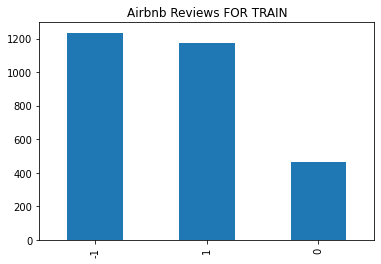

In [6]:
y_train.label.value_counts().plot(kind='bar',title="Airbnb Reviews FOR TRAIN")
print(y_train.label.value_counts())

 1    553
-1    509
 0    170
Name: label, dtype: int64


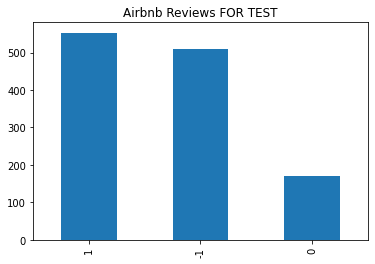

In [7]:
y_test.label.value_counts().plot(kind='bar',title="Airbnb Reviews FOR TEST")
print(y_test.label.value_counts())

## <font color='RED'> Export Train and Test Datasets to CSV Files </font>

In [8]:
print('x_train.shape',x_train.shape)
x_train

x_train.shape (2873, 1)


,comments
3616,matthieu place clean bed broken sleep mattress...
3487,look place sleep downtown cheep place
1070,cold cover bed two small blanket cover whole b...
2132,afford space vancouv trip
2943,clean contemporari comfort hostess clearli car...
...,...
338,locat ideal airport richmond night market base...
1628,appart uncomfort smellmad stay littl overwhelm...
1047,love littl shutter window bunk bed room live r...
3659,would trust host take payment cancel book less...


In [9]:
print('y_train.shape',y_train.shape)
y_train

y_train.shape (2873, 1)


,label
3616,-1
3487,0
1070,-1
2132,0
2943,1
...,...
338,1
1628,-1
1047,1
3659,-1


In [10]:
print('len(train_comment)=',len(train_comment))
print('len(train_label)=',len(train_label))
print('len(test_comment)=',len(test_comment))
print('len(test_label)=',len(test_label))

len(train_comment)= 2873
len(train_label)= 2873
len(test_comment)= 1232
len(test_label)= 1232


In [11]:
df_train = pd.DataFrame({'index_col': train_idx, 'train_comment':train_comment}).set_index('index_col',drop=True)
df_train_label = pd.DataFrame({'index_col': train_idx, 'train_label':train_label}).set_index('index_col',drop=True)
df_train_sample = pd.merge(df_train, df_train_label, left_index=True, right_index=True)
df_train_sample = pd.merge(df[['listing_id','city','comments_orig']], df_train_sample, left_index=True, right_index=True)
print('df_train_sample.shape:',df_train_sample.shape)
file_name = sampling_folder + 'sample_reviews_train.csv' 
df_train_sample.to_csv(file_name, index = False)


df_test = pd.DataFrame({'index_col': test_idx, 'test_comment':test_comment}).set_index('index_col',drop=True)
df_test_label = pd.DataFrame({'index_col': test_idx, 'test_label':test_label}).set_index('index_col',drop=True)
df_test_sample = pd.merge(df_test, df_test_label, left_index=True, right_index=True)
df_test_sample = pd.merge(df[['listing_id','city','comments_orig']], df_test_sample, left_index=True, right_index=True)
print('df_test_sample.shape:',df_test_sample.shape)
file_name = sampling_folder + 'sample_reviews_test.csv' 
df_test_sample.to_csv(file_name, index = False)

df_train_sample.shape: (2873, 5)
df_test_sample.shape: (1232, 5)


### Common functions

In [12]:
def plot_confusion_matrix(cm, classes,normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
#     https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')    
    return

def calc_rsquare_mae(model_name, model_obj, x_train, y_train, y_train_pred, x_test, y_test, y_test_pred):  
    MAE_train=np.mean(abs(y_train-y_train_pred))/np.mean(y_test)
    MAE_test=np.mean(abs(y_test-y_test_pred))/np.mean(y_test)
#     print("Tree on train set MAE%:", round(MAE_train*100,1))
#     print("Tree on test set MAE%:", round(MAE_test*100,1))
    RsquareScoreTrain = model_obj.score(x_train, y_train)
    RsquareScoreTest = model_obj.score(x_test, y_test)    
    result={'Model':[model_name],'Rsquare Train':[RsquareScoreTrain],'R-square Test':[RsquareScoreTest],'MAE Train':[round(MAE_train*100,1)],'MAE Test':[round(MAE_test*100,1)]}
    return result

 
def calc_confusion_matrix(y_true, y_pred, model_name, class_names,n_class):
    #https://machinelearningcoban.com/2017/08/31/evaluation/
    df_confusion = confusion_matrix(y_true, y_pred)
    normalized_df_confusion = df_confusion/df_confusion.sum(axis = 1, keepdims = True)    
        
    # Plot confusion matrix
    plt.figure()
    plot_confusion_matrix(df_confusion, classes=class_names,normalize=True,title=('Confusion matrix ',model_name))
    plt.show()    
     
    return df_confusion


## <font color='RED'> Models </font>

In [13]:
import pickle
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import ParameterGrid

## BOW
# save_classifier = open("./data/output_models/bowGradientBoostedClfModel.pickle","wb")
# pickle.dump(m_bow_gdb, save_classifier)
# save_classifier.close()


def cov_list_of_words_to_sent(words):
    sentence=' '
    for w in words : 
        sentence += " " + w # adding space b/w 2 words
    return sentence

def save_embedding(file_name, converter):
    features = cov_list_of_words_to_sent(converter.get_feature_names())
    # print(features)
    feature_file_name = saved_embedding + file_name
    text_file = open(feature_file_name, "w")
    text_file.write(features)
    text_file.close()
    
def save_models(model_obj, file_name):
    file = saved_models + file_name
    save_classifier = open(file,"wb")
    pickle.dump(model_obj, save_classifier)
    save_classifier.close()
    return


def find_optimal_params(clf,grid,x_train,y_train,x_test,y_test):    
    test_scores = []
    optimal_grid=[]
    for g in ParameterGrid(grid):
        clf.set_params(**g) # ** is "unpacking" the dictionary
        clf.fit(x_train, y_train)
        test_scores.append(clf.score(x_test, y_test))
        #print('grid:',g, ' Score:', clf.score(x_test, y_test))
                           
    # Find best hyperparameters using the test score
    best_idx = np.argmax(test_scores)
    optimal_grid = ParameterGrid(grid)[best_idx]
    print('The best hyperparameter:', test_scores[best_idx], ParameterGrid(grid)[best_idx])
    return optimal_grid


def test_clf_model(clf, x_train,y_train,x_test,y_test,model_name,class_names, n_class):
    # Predicting the Test set results 
    start_time = time.time()    
    y_train_pred= clf.predict(x_train)
    y_test_pred = clf.predict(x_test)    
    test_duration = time.time() - start_time
    
    start_time = time.time()
    df_cm = calc_confusion_matrix(y_test,y_test_pred, model_name,class_names,n_class) 
    cm_duration = time.time() - start_time
    
    start_time = time.time()
    print('CLASSIFICATION REPORT: ', model_name)
    print(classification_report(y_test,y_test_pred))
    precision,recall,fscore,support=score(y_test,y_test_pred,average='macro')
    accuracy=accuracy_score(y_test, y_test_pred) 
    result = calc_rsquare_mae(model_name, clf, x_train, y_train, y_train_pred, x_test, y_test, y_test_pred)
    clfreport_duration = time.time() - start_time
         
    result['Accuracy']=accuracy
    result['Fscore']=fscore
    result['Precision']=precision
    result['Recall']=recall
    result['Support']=support  
    result['Test Duration']=test_duration
    result['Confusion Martrix Duration']=cm_duration
    result['Classification Report Duration']=clfreport_duration
    return result

    
def naivebayes(x_train,y_train,x_test,y_test,class_names, n_class,df_acc):
    model_name='NAIVE BAYES'
    print('=========================MODEL NAME: ', model_name, '=========================')    
    start_time = time.time()
    clf_model = GaussianNB()
    clf_model.fit(x_train, y_train)
    training_duration = time.time() - start_time
       
    result = test_clf_model(clf_model, x_train,y_train,x_test,y_test,model_name,class_names, n_class)  
    result['Training_duration']=training_duration
    df_acc = df_acc.append(pd.DataFrame(result),ignore_index=True)
    return df_acc, clf_model



def knn(x_train,y_train,x_test,y_test,class_names, n_class,df_acc,optgrid):
    model_name='KNN'
    print('=========================MODEL NAME: ', model_name, '=========================')

    if not(optgrid):
        grid = {'n_neighbors': [3,5,7,9,15,20,30]}     
#         The best hyperparameter: 0.6622447802514707 {'n_neighbors': 3}     
        clf_model = KNeighborsClassifier(n_neighbors= 3) 
        optimal_grid = find_optimal_params(clf_model,grid,x_train,y_train,x_test,y_test)
    else:
        optimal_grid = optgrid

    start_time = time.time()
    clf_model = KNeighborsClassifier(n_neighbors= optimal_grid['n_neighbors'])
    clf_model.fit(x_train, y_train)
    training_duration = time.time() - start_time

    result = test_clf_model(clf_model, x_train,y_train,x_test,y_test,model_name,class_names, n_class)  
    result['Training_duration']=training_duration  
    df_acc = df_acc.append(pd.DataFrame(result),ignore_index=True)
    return df_acc, clf_model


def SVM(x_train,y_train,x_test,y_test,class_names, n_class,df_acc,optgrid):
    model_name='Support Vector Machine Model'
    print('=========================MODEL NAME: ', model_name, '=========================')
    
    if not(optgrid):
        grid = {'C': [0.01, 0.05, 1, 10, 100, 1000], 'kernel': ['linear','rbf','sigmoid'],'gamma': [0.001, 0.0001, 0.01]}  
        #bow - The best hyperparameter: 0.9221363479063329 {'kernel': 'rbf', 'gamma': 0.01, 'C': 10}
        clf_model = SVC(kernel= 'rbf', C=100, gamma=0.001)
        optimal_grid = find_optimal_params(clf_model,grid,x_train,y_train,x_test,y_test)
    else:
        optimal_grid=optgrid
    
    # Fitting classifier to the Training set    
    start_time = time.time()
    clf_model = SVC(kernel= optimal_grid['kernel'], C= optimal_grid['C'], gamma= optimal_grid['gamma'],cache_size=4000,verbose =True)
    clf_model.fit(x_train, y_train)    
    training_duration = time.time() - start_time    

    result = test_clf_model(clf_model, x_train,y_train,x_test,y_test,model_name,class_names, n_class)  
    result['Training_duration']=training_duration   
    df_acc = df_acc.append(pd.DataFrame(result),ignore_index=True)    
    return df_acc, clf_model


def decision_tree_clf(x_train,y_train,x_test,y_test,class_names, n_class,df_acc,optgrid):
    model_name='Decision Tree Classification Model'
    print('=========================MODEL NAME: ', model_name, '=========================')

    if not(optgrid):    
        grid = {'max_depth': [50,70,90,100,200,400], 'min_samples_leaf': [2,4,6,8], 'random_state': [prandom_state]} 
        #bow - The best hyperparameter: 0.8386203714384589 {'random_state': 523, 'min_samples_leaf': 4, 'max_depth': 100}
        clf_model = DecisionTreeClassifier(max_depth = 100, min_samples_leaf= 4, random_state = 523) 
        optimal_grid = find_optimal_params(clf_model,grid,x_train,y_train,x_test,y_test)
    else:
        optimal_grid=optgrid
    
    # Fitting classifier to the Training set with the optimal parameters
    start_time = time.time()  
    clf_model = DecisionTreeClassifier(max_depth = optimal_grid['max_depth'], min_samples_leaf= optimal_grid['min_samples_leaf'], random_state = optimal_grid['random_state']) 
    clf_model.fit(x_train, y_train)    
    training_duration = time.time() - start_time

    result = test_clf_model(clf_model, x_train,y_train,x_test,y_test,model_name,class_names, n_class)  
    result['Training_duration']=training_duration
    df_acc = df_acc.append(pd.DataFrame(result),ignore_index=True)
    return df_acc, clf_model

def random_forest_clf(x_train,y_train,x_test,y_test,class_names, n_class,df_acc,optgrid):
    model_name='Random Forest Classifier'
    print('=========================MODEL NAME: ', model_name, '=========================')    

    if not(optgrid): 
        grid = {'n_estimators': [10,20,30,50,70,90,100,150,200], 'max_depth': [3,5,7,9,10,20,50], 'max_features': [2,4,6,8], 'random_state': [prandom_state]}
#         bow -The best hyperparameter: 0.6667435690391048 {'random_state': 523, 'n_estimators': 150, 'max_features': 8, 'max_depth': 50}    
#         tf: The best hyperparameter: 0.536278694197716 {'random_state': 523, 'n_estimators': 20, 'max_features': 8, 'max_depth': 9}
        clf_model = RandomForestClassifier(n_estimators = 150 , criterion = 'entropy', max_depth = 50, max_features=8, random_state = 523) 
        optimal_grid = find_optimal_params(clf_model,grid,x_train,y_train,x_test,y_test)
    else:
        optimal_grid=optgrid
    
    start_time = time.time()
    clf_model = RandomForestClassifier(n_estimators = optimal_grid['n_estimators'] , criterion = 'entropy', max_depth = optimal_grid['max_depth'], max_features=optimal_grid['max_features'], random_state = optimal_grid['random_state']) 
    clf_model.fit(x_train, y_train)    
    training_duration = time.time() - start_time

    result = test_clf_model(clf_model, x_train,y_train,x_test,y_test,model_name,class_names, n_class)  
    result['Training_duration']=training_duration 
    df_acc = df_acc.append(pd.DataFrame(result),ignore_index=True)  
    return df_acc, clf_model

def GradientBoostedclf(x_train,y_train,x_test,y_test,class_names, n_class,df_acc,optgrid):
    model_name='Gradient Boosted Tree Classifier'
    print('=========================MODEL NAME: ', model_name, '=========================')

    if not(optgrid):     
        grid = {'n_estimators': [50,90,100,200,300,500,1000], 'learning_rate': [0.01,0.05,0.07,0.09,0.1,0.5], 'max_features': [3,5,7,9], 'random_state': [prandom_state]}
        #The best hyperparameter: 0.8882224016610912 {'random_state': 523, 'n_estimators': 1000, 'max_features': 7, 'learning_rate': 0.5}
        clf_model = GradientBoostingClassifier(max_features=7,
                                    learning_rate=0.5,
                                    n_estimators=1000,
                                    subsample=0.6,
                                    random_state=523)
        optimal_grid = find_optimal_params(clf_model,grid,x_train,y_train,x_test,y_test)
    else:    
        optimal_grid=optgrid
    
    start_time = time.time()
    clf_model = GradientBoostingClassifier(max_features=optimal_grid['max_features'],learning_rate=optimal_grid['learning_rate'],n_estimators=optimal_grid['n_estimators'],
                                subsample= 0.7,random_state=optimal_grid['random_state']) 
    clf_model.fit(x_train, y_train)
    training_duration = time.time() - start_time
    
    result = test_clf_model(clf_model, x_train,y_train,x_test,y_test,model_name,class_names, n_class)  
    result['Training_duration']=training_duration
    df_acc = df_acc.append(pd.DataFrame(result),ignore_index=True)    
    return df_acc, clf_model

# <font color='GREEN'> 1. FE - Bag of Words (BOW) </font> 

In [14]:
# Create the bag of words model
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer() #max_features= 10000
cv.fit(X)

x_train_vect = cv.fit_transform(train_comment).toarray()
x_test_vect = cv.transform(test_comment).toarray()
y_train = np.array(train_label)
y_test = np.array(test_label)

print('Vectorizer max features :', cv)
print('x_train_vect AFTER BOW vectorizing: ',x_train_vect.shape)
print('y_train AFTER BOW vectorizing: ',y_train.shape)
print('x_test_vect AFTER BOW vectorizing: ',x_test_vect.shape)
print('y_test AFTER BOW vectorizing: ',y_test.shape)

# # get all unique words in the corpus
# vocab = cv.get_feature_names()
# # show document feature vectors
# pd.DataFrame(cv_matrix, columns=vocab)

Vectorizer max features : CountVectorizer()
x_train_vect AFTER BOW vectorizing:  (2873, 5927)
y_train AFTER BOW vectorizing:  (2873,)
x_test_vect AFTER BOW vectorizing:  (1232, 5927)
y_test AFTER BOW vectorizing:  (1232,)


=========================MODEL NAME:  NAIVE BAYES =========================


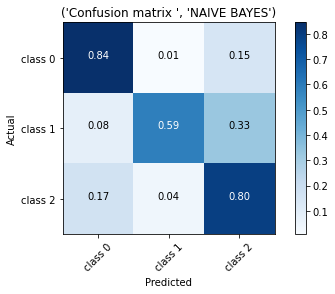

CLASSIFICATION REPORT:  NAIVE BAYES
              precision    recall  f1-score   support

          -1       0.80      0.84      0.82       509
           0       0.80      0.59      0.68       170
           1       0.77      0.80      0.78       553

    accuracy                           0.79      1232
   macro avg       0.79      0.74      0.76      1232
weighted avg       0.79      0.79      0.78      1232

=========================MODEL NAME:  KNN =========================


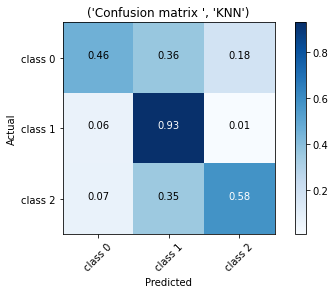

CLASSIFICATION REPORT:  KNN
              precision    recall  f1-score   support

          -1       0.83      0.46      0.59       509
           0       0.29      0.93      0.45       170
           1       0.78      0.58      0.66       553

    accuracy                           0.58      1232
   macro avg       0.63      0.66      0.57      1232
weighted avg       0.73      0.58      0.60      1232

=========================MODEL NAME:  Support Vector Machine Model =========================
[LibSVM]

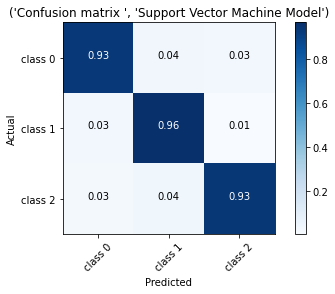

CLASSIFICATION REPORT:  Support Vector Machine Model
              precision    recall  f1-score   support

          -1       0.96      0.93      0.95       509
           0       0.80      0.96      0.87       170
           1       0.97      0.93      0.95       553

    accuracy                           0.94      1232
   macro avg       0.91      0.94      0.92      1232
weighted avg       0.94      0.94      0.94      1232

=========================MODEL NAME:  Decision Tree Classification Model =========================


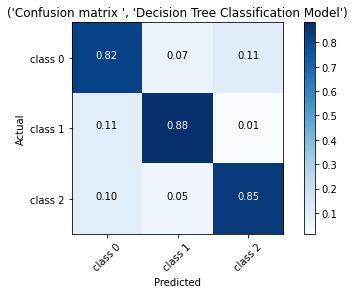

CLASSIFICATION REPORT:  Decision Tree Classification Model
              precision    recall  f1-score   support

          -1       0.85      0.82      0.83       509
           0       0.71      0.88      0.79       170
           1       0.89      0.85      0.87       553

    accuracy                           0.84      1232
   macro avg       0.81      0.85      0.83      1232
weighted avg       0.85      0.84      0.84      1232

=========================MODEL NAME:  Random Forest Classifier =========================


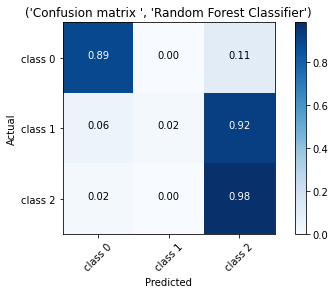

CLASSIFICATION REPORT:  Random Forest Classifier
              precision    recall  f1-score   support

          -1       0.96      0.89      0.92       509
           0       1.00      0.02      0.03       170
           1       0.72      0.98      0.83       553

    accuracy                           0.81      1232
   macro avg       0.89      0.63      0.60      1232
weighted avg       0.86      0.81      0.76      1232

=========================MODEL NAME:  Gradient Boosted Tree Classifier =========================


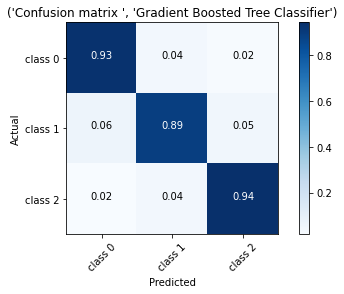

CLASSIFICATION REPORT:  Gradient Boosted Tree Classifier
              precision    recall  f1-score   support

          -1       0.96      0.93      0.95       509
           0       0.77      0.89      0.83       170
           1       0.96      0.94      0.95       553

    accuracy                           0.93      1232
   macro avg       0.90      0.92      0.91      1232
weighted avg       0.93      0.93      0.93      1232



In [15]:
df_acc_bow = pd.DataFrame()
prandom_state=523
n_class=3
class_names = ['class 0','class 1','class 2']
xtrain= x_train_vect
ytrain = y_train
xtest = x_test_vect
ytest = y_test

df_acc_bow, m_bow_naive = naivebayes(xtrain,ytrain,xtest,ytest,class_names, n_class,df_acc_bow)

#The best hyperparameter: 0.6622447802514707 {'n_neighbors': 3}
grid = {'n_neighbors': 3} 
df_acc_bow, m_bow_knn = knn(xtrain,ytrain,xtest,ytest,class_names, n_class,df_acc_bow,grid)

#The best hyperparameter: 0.9221363479063329 {'kernel': 'rbf', 'gamma': 0.01, 'C': 10}
grid = {'kernel': 'rbf', 'gamma': 0.01, 'C': 10}
df_acc_bow, m_bow_svm = SVM(xtrain,ytrain,xtest,ytest,class_names, n_class,df_acc_bow,grid)

#The best hyperparameter: 0.8386203714384589 {'random_state': 523, 'min_samples_leaf': 4, 'max_depth': 100}
grid={'random_state': 523, 'min_samples_leaf': 4, 'max_depth': 100}
df_acc_bow, m_bow_dct = decision_tree_clf(xtrain,ytrain,xtest,ytest,class_names,n_class,df_acc_bow,grid)

#The best hyperparameter: 0.6667435690391048 {'random_state': 523, 'n_estimators': 150, 'max_features': 8, 'max_depth': 50}
grid={'random_state': 523, 'n_estimators': 150, 'max_features': 8, 'max_depth': 50}
df_acc_bow, m_bow_rft  = random_forest_clf(xtrain,ytrain,xtest,ytest,class_names,n_class,df_acc_bow,grid)

#The best hyperparameter: 0.8882224016610912 {'random_state': 523, 'n_estimators': 1000, 'max_features': 7, 'learning_rate': 0.5}
grid={'random_state': 523, 'n_estimators': 1000, 'max_features': 7, 'learning_rate': 0.5}
df_acc_bow, m_bow_gdb  = GradientBoostedclf(xtrain,ytrain,xtest,ytest,class_names,n_class,df_acc_bow,grid)

df_acc_bow['Feature Engineering'] = 'BoW'

In [16]:
df_acc_bow.sort_values(by=['Fscore','Accuracy', 'Rsquare Train','R-square Test'], inplace=True, ascending=False)
df_acc_bow

,Model,Rsquare Train,R-square Test,MAE Train,MAE Test,Accuracy,Fscore,Precision,Recall,Support,Test Duration,Confusion Martrix Duration,Classification Report Duration,Training_duration,Feature Engineering
2,Support Vector Machine Model,0.988862,0.938312,36.1,238.6,0.938312,0.924648,0.910507,0.944270,None,25.886289,0.308147,25.166382,52.573105,BoW
5,Gradient Boosted Tree Classifier,0.994779,0.931006,16.6,243.2,0.931006,0.908380,0.898351,0.921190,None,0.591360,0.210440,0.615381,8.153292,BoW
3,Decision Tree Classification Model,0.922381,0.840909,336.2,706.8,0.840909,0.829151,0.815000,0.849903,None,0.076835,0.218415,0.083734,2.109359,BoW
0,NAIVE BAYES,0.940480,0.787338,309.9,975.0,0.787338,0.761284,0.790939,0.742896,None,1.159897,0.272273,1.147930,0.493833,BoW
4,Random Forest Classifier,0.833623,0.811688,514.6,675.0,0.811688,0.596255,0.892791,0.630451,None,0.468746,0.214427,0.501656,2.120331,BoW
1,KNN,0.785590,0.577110,739.7,1475.0,0.577110,0.566373,0.632680,0.655330,None,1.999652,0.333109,2.183161,0.000998,BoW


#### <font color='GREEN'> Save extracted Features + Good Models </font> 

In [17]:
### BOW Extract Features
features_filename=''
features_filename = 'bow_features.txt'
save_embedding(features_filename, cv)

## BOW - good classifier models
modelfinename=''
modelfinename = "bowGradientBoostedClfModel.pickle"
save_models(m_bow_gdb, modelfinename)

modelfinename = "bowSVMClfModel.pickle"
save_models(m_bow_svm, modelfinename)

# <font color='GREEN'> 2. TF - IDF </font> 

In [18]:
## Create a TF-IDF model
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

tfv = TfidfVectorizer(analyzer='word',ngram_range=(1,3), token_pattern=r'\w{1,}',max_features=10000,stop_words=stopwords.words('english')) 
tfv.fit(X)

x_train_tfv =  tfv.fit_transform(train_comment).toarray()
x_test_tfv =  tfv.transform(test_comment).toarray()
y_train = np.array(train_label)
y_test = np.array(test_label)

# tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=100000)
# tfidf_vect.fit(train_clean['tweet'])
# xtrain_tfidf =  tfidf_vect.transform(train_x)
# xvalid_tfidf =  tfidf_vect.transform(valid_x)

In [19]:
print('Vectorizer max features :', tfv)
print('x_train_tfv AFTER TF-IDF vectorizing: ',x_train_tfv.shape)
print('y_train.shape: ',y_train.shape)
print('x_test_tfv AFTER TF-IDF vectorizing: ',x_test_tfv.shape)
print('y_test.shape: ',y_test.shape)
# print(tfv.get_feature_names())

Vectorizer max features : TfidfVectorizer(max_features=10000, ngram_range=(1, 3),
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...],
                token_pattern='\\w{1,}')
x_train_tfv AFTER TF-IDF vectorizing:  (2873, 10000)
y_train.shape:  (2873,)
x_test_tfv AFTER TF-IDF vectorizing:  (1232, 10000)
y_test.shape:  (1232,)


=========================MODEL NAME:  NAIVE BAYES =========================


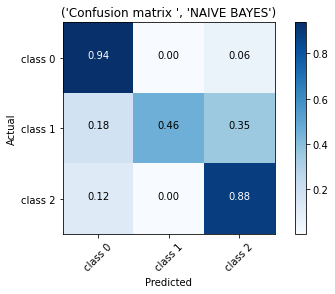

CLASSIFICATION REPORT:  NAIVE BAYES
              precision    recall  f1-score   support

          -1       0.83      0.94      0.88       509
           0       0.98      0.46      0.63       170
           1       0.84      0.88      0.86       553

    accuracy                           0.85      1232
   macro avg       0.88      0.76      0.79      1232
weighted avg       0.86      0.85      0.84      1232

=========================MODEL NAME:  KNN =========================


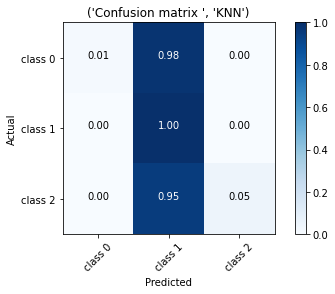

CLASSIFICATION REPORT:  KNN
              precision    recall  f1-score   support

          -1       1.00      0.01      0.03       509
           0       0.14      1.00      0.25       170
           1       0.96      0.05      0.09       553

    accuracy                           0.17      1232
   macro avg       0.70      0.35      0.12      1232
weighted avg       0.87      0.17      0.09      1232

=========================MODEL NAME:  Support Vector Machine Model =========================
[LibSVM]

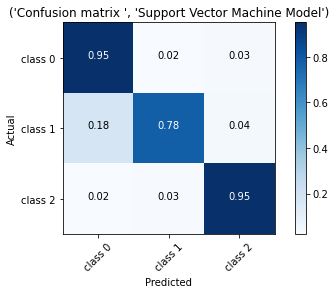

CLASSIFICATION REPORT:  Support Vector Machine Model
              precision    recall  f1-score   support

          -1       0.92      0.95      0.93       509
           0       0.84      0.78      0.81       170
           1       0.96      0.95      0.96       553

    accuracy                           0.93      1232
   macro avg       0.91      0.89      0.90      1232
weighted avg       0.93      0.93      0.93      1232

=========================MODEL NAME:  Decision Tree Classification Model =========================


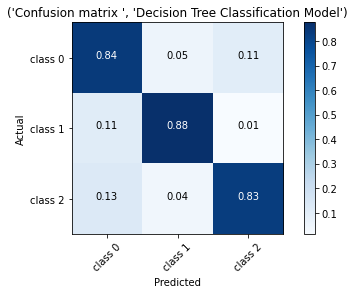

CLASSIFICATION REPORT:  Decision Tree Classification Model
              precision    recall  f1-score   support

          -1       0.83      0.84      0.83       509
           0       0.75      0.88      0.81       170
           1       0.89      0.83      0.86       553

    accuracy                           0.84      1232
   macro avg       0.82      0.85      0.83      1232
weighted avg       0.85      0.84      0.84      1232

=========================MODEL NAME:  Random Forest Classifier =========================


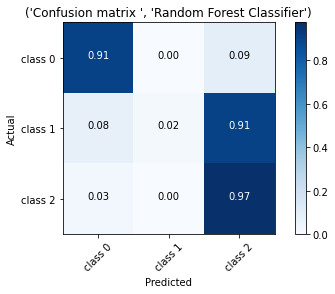

CLASSIFICATION REPORT:  Random Forest Classifier
              precision    recall  f1-score   support

          -1       0.94      0.91      0.92       509
           0       1.00      0.02      0.03       170
           1       0.73      0.97      0.83       553

    accuracy                           0.81      1232
   macro avg       0.89      0.63      0.60      1232
weighted avg       0.85      0.81      0.76      1232

=========================MODEL NAME:  Gradient Boosted Tree Classifier =========================


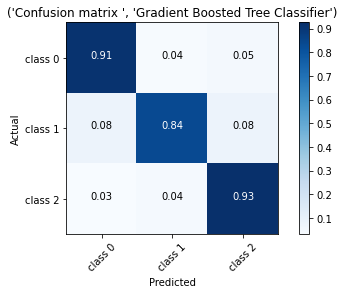

CLASSIFICATION REPORT:  Gradient Boosted Tree Classifier
              precision    recall  f1-score   support

          -1       0.94      0.91      0.93       509
           0       0.77      0.84      0.80       170
           1       0.93      0.93      0.93       553

    accuracy                           0.91      1232
   macro avg       0.88      0.89      0.88      1232
weighted avg       0.91      0.91      0.91      1232



In [20]:
df_acc_tf = pd.DataFrame()
n_class=3
class_names = ['class 0','class 1','class 2']
xtrain= x_train_tfv
ytrain = y_train
xtest = x_test_tfv
ytest = y_test

df_acc_tf, m_idf_naive = naivebayes(xtrain,ytrain,xtest,ytest,class_names, n_class,df_acc_tf)

#The best hyperparameter: 0.27546429807359557 {'n_neighbors': 3}
optgrid={'n_neighbors': 3}
df_acc_tf, m_idf_knn = knn(xtrain,ytrain,xtest,ytest,class_names, n_class,df_acc_tf,optgrid)

#The best hyperparameter: 0.9212135194370746 {'kernel': 'linear', 'gamma': 0.001, 'C': 1}
optgrid={'kernel': 'linear', 'gamma': 0.001, 'C': 1}
df_acc_tf, m_idf_svm = SVM(xtrain,ytrain,xtest,ytest,class_names, n_class,df_acc_tf,optgrid)

#The best hyperparameter: 0.8327373399469373 {'random_state': 523, 'min_samples_leaf': 8, 'max_depth': 200}
optgrid={'random_state': 523, 'min_samples_leaf': 8, 'max_depth': 200}
df_acc_tf, m_idf_dct = decision_tree_clf(xtrain,ytrain,xtest,ytest,class_names,n_class,df_acc_tf,optgrid)

#The best hyperparameter: 0.6660514476871612 {'random_state': 523, 'n_estimators': 150, 'max_features': 8, 'max_depth': 50}
optgrid={'random_state': 523, 'n_estimators': 150, 'max_features': 8, 'max_depth': 50}
df_acc_tf, m_idf_rft = random_forest_clf(xtrain,ytrain,xtest,ytest,class_names,n_class,df_acc_tf,optgrid)

#The best hyperparameter: 0.8919137155381244 {'random_state': 523, 'n_estimators': 1000, 'max_features': 9, 'learning_rate': 0.5}
optgrid={'random_state': 523, 'n_estimators': 1000, 'max_features': 9, 'learning_rate': 0.5}
df_acc_tf, m_idf_gdb = GradientBoostedclf(xtrain,ytrain,xtest,ytest,class_names,n_class,df_acc_tf,optgrid)

df_acc_tf['Feature Engineering'] = 'TF-IDF'

In [21]:
df_acc_tf['Feature Engineering'] = 'TF-IDF'
df_acc_tf.sort_values(by=['Fscore','Accuracy', 'Rsquare Train','R-square Test'], inplace=True, ascending=False)
df_acc_tf

,Model,Rsquare Train,R-square Test,MAE Train,MAE Test,Accuracy,Fscore,Precision,Recall,Support,Test Duration,Confusion Martrix Duration,Classification Report Duration,Training_duration,Feature Engineering
2,Support Vector Machine Model,0.994779,0.926948,18.5,265.9,0.926948,0.899414,0.905444,0.894149,None,38.775640,0.221405,40.337774,127.451061,TF-IDF
5,Gradient Boosted Tree Classifier,0.997912,0.908279,5.8,352.3,0.908279,0.884303,0.878096,0.891570,None,0.698104,0.278256,0.742024,8.035508,TF-IDF
3,Decision Tree Classification Model,0.895231,0.841721,462.0,727.3,0.841721,0.834632,0.823418,0.849720,None,0.120704,0.226366,0.141620,4.105088,TF-IDF
0,NAIVE BAYES,0.983641,0.847403,84.8,643.2,0.847403,0.791396,0.884019,0.761432,None,1.515974,0.205422,1.424263,0.618345,TF-IDF
4,Random Forest Classifier,0.830143,0.814123,520.4,661.4,0.814123,0.597511,0.890689,0.632676,None,0.551529,0.216423,0.562498,2.340768,TF-IDF
1,KNN,0.201880,0.165584,2235.7,2338.6,0.165584,0.122932,0.702102,0.354192,None,2.918196,0.297208,2.768592,0.041888,TF-IDF


In [22]:
df_acc = df_acc_bow.copy()
df_acc=df_acc.append(df_acc_tf)
df_acc.sort_values(by=['Fscore','Accuracy', 'Rsquare Train','R-square Test'], inplace=True, ascending=False)
df_acc

,Model,Rsquare Train,R-square Test,MAE Train,MAE Test,Accuracy,Fscore,Precision,Recall,Support,Test Duration,Confusion Martrix Duration,Classification Report Duration,Training_duration,Feature Engineering
2,Support Vector Machine Model,0.988862,0.938312,36.1,238.6,0.938312,0.924648,0.910507,0.944270,None,25.886289,0.308147,25.166382,52.573105,BoW
5,Gradient Boosted Tree Classifier,0.994779,0.931006,16.6,243.2,0.931006,0.908380,0.898351,0.921190,None,0.591360,0.210440,0.615381,8.153292,BoW
2,Support Vector Machine Model,0.994779,0.926948,18.5,265.9,0.926948,0.899414,0.905444,0.894149,None,38.775640,0.221405,40.337774,127.451061,TF-IDF
5,Gradient Boosted Tree Classifier,0.997912,0.908279,5.8,352.3,0.908279,0.884303,0.878096,0.891570,None,0.698104,0.278256,0.742024,8.035508,TF-IDF
3,Decision Tree Classification Model,0.895231,0.841721,462.0,727.3,0.841721,0.834632,0.823418,0.849720,None,0.120704,0.226366,0.141620,4.105088,TF-IDF
3,Decision Tree Classification Model,0.922381,0.840909,336.2,706.8,0.840909,0.829151,0.815000,0.849903,None,0.076835,0.218415,0.083734,2.109359,BoW
0,NAIVE BAYES,0.983641,0.847403,84.8,643.2,0.847403,0.791396,0.884019,0.761432,None,1.515974,0.205422,1.424263,0.618345,TF-IDF
0,NAIVE BAYES,0.940480,0.787338,309.9,975.0,0.787338,0.761284,0.790939,0.742896,None,1.159897,0.272273,1.147930,0.493833,BoW
4,Random Forest Classifier,0.830143,0.814123,520.4,661.4,0.814123,0.597511,0.890689,0.632676,None,0.551529,0.216423,0.562498,2.340768,TF-IDF
4,Random Forest Classifier,0.833623,0.811688,514.6,675.0,0.811688,0.596255,0.892791,0.630451,None,0.468746,0.214427,0.501656,2.120331,BoW


#### <font color='GREEN'> Save extracted Features + Good Models </font> 

In [23]:
### BOW Extract Features
features_filename = 'tfidf_features.txt'
save_embedding(features_filename, tfv)

## TF-IDF
modelfinename = "idfGradientBoostedClfModel.pickle"
save_models(m_idf_gdb, modelfinename)

modelfinename = "idfSVMClfModel.pickle"
save_models(m_idf_svm, modelfinename)

# <font color='GREEN'> 3. WORD2VEC - SKIP GRAM with GENSIM </font> 


#### <font color='GREEN'> build corpus with sample dataset using pre-trained Gensim Word2Vec model </font>

In [24]:
tokenizer = RegexpTokenizer(r'\w+')
df['tokenized_comments'] = df['comments'].apply(lambda x: tokenizer.tokenize(str(x)))
print('df.shape:',df.shape)
df.head(5)

df.shape: (4105, 7)


,listing_id,comments,label,city,lang,comments_orig,tokenized_comments
0,30346862,wonder locat iman make check easi patioth best...,1,vancouver,en,What a wonderful location! Iman made checking ...,"[wonder, locat, iman, make, check, easi, patio..."
1,39151461,photoshop fake pictur,-1,ottawa,en,photoshopped fake pictures ...,"[photoshop, fake, pictur]"
2,17191132,tri tow car call airbnb heat issu somehow hop ...,-1,ottawa,en,They tried to tow our car after we called Airb...,"[tri, tow, car, call, airbnb, heat, issu, some..."
3,29186162,heat bedroom enough,0,toronto,en,Heating in the bedroom is not enough,"[heat, bedroom, enough]"
4,1365638,host cancel reserv day arriv autom post,0,toronto,en,The host canceled this reservation 8 days befo...,"[host, cancel, reserv, day, arriv, autom, post]"


In [25]:
from gensim.models import Word2Vec
   
# Skip-gram model (sg = 1)
dim_size = 256 # The number of dimensions of the embeddings and the default is 100
window = 5 # The maximum distance between a target word and words around the target word. The default window is 5
min_count = 1 # The minimum count of words to consider when training the model; words with occurrence less than this count will be ignored. The default for min_count is 5
workers = 3 # The number of partitions during training and the default workers is 3.
sg = 1  #The training algorithm, either CBOW(0) or skip gram(1). The default training algorithm is CBOW

word2vec_model_file = saved_models + 'w2vect_gensim_sg_' + str(dim_size) + '.model'

start_time = time.time()
tokenized_comments = pd.Series(df['tokenized_comments']).values

# Train the Word2Vec Model
w2v_model = Word2Vec(tokenized_comments, min_count = min_count, size = dim_size, workers = workers, window = window, sg = sg)

print("Time taken to train word2vec model: " + str(time.time() - start_time))

w2v_model.save(word2vec_model_file)

# summarize the loaded model
print(w2v_model)

Time taken to train word2vec model: 4.311475515365601
Word2Vec(vocab=7053, size=256, alpha=0.025)


In [26]:
#print('list of word:',w2v_model.wv.vocab)

In [27]:
w2v_model.most_similar(['beauti'])

[('cozi', 0.9915554523468018),
 ('love', 0.990344226360321),
 ('stylish', 0.9901220798492432),
 ('cute', 0.9843988418579102),
 ('decor', 0.983670711517334),
 ('sparkl', 0.982488214969635),
 ('spaciou', 0.9808374643325806),
 ('view', 0.9800513982772827),
 ('perfect', 0.9788838624954224),
 ('nice', 0.9776437282562256)]

In [28]:
w2v_model.most_similar(['dirti'])

[('filthi', 0.9651981592178345),
 ('blanket', 0.9564186334609985),
 ('sheet', 0.9562816619873047),
 ('disgust', 0.9496893882751465),
 ('towel', 0.9472294449806213),
 ('pillow', 0.9464882612228394),
 ('unclean', 0.9460826516151428),
 ('stain', 0.9454277753829956),
 ('linen', 0.9441598653793335),
 ('hair', 0.9435825347900391)]

#### <font color='GREEN'> load saved model </font>

In [29]:
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Load the model from the model file
sg_w2v_model = Word2Vec.load(word2vec_model_file)

#### <font color='GREEN'> vectorize train data with n_Skip_Gram model to prepare for training, then export to csv file </font>

In [30]:
x_train['tokenized_comments'] = x_train['comments'].apply(lambda x: tokenizer.tokenize(str(x)))
x_test['tokenized_comments'] = x_test['comments'].apply(lambda x: tokenizer.tokenize(str(x)))

<ipython-input-30-950a0da524fe>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-30-950a0da524fe>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
def vectorize_data_sg_gensim(sg_w2v_model, df, colname, output_filename, dim_size):
    with open(output_filename, 'w+') as word2vec_file:
        for index, row in df.iterrows():
                model_vector = (np.mean([sg_w2v_model[token] for token in row[colname]], axis=0)).tolist()
#                 print('row:',row, ' - index =',index)                
#                 if index == 0:      
#                     print('1- Type(model_vector): ', type(model_vector), '- Index: ', index)
#                     header = ",".join(str(ele) for ele in range(dim_size))                    
#                     word2vec_file.write(header)
#                     word2vec_file.write("\n")
                # Check if the line exists else it is vector of zeros
                if type(model_vector) is list:  
                    line1 = ",".join( [str(vector_element) for vector_element in model_vector] )
                else:
                    line1 = ",".join([str(0) for i in range(dim_size)])
#                     print('2- Type(model_vector): ', type(model_vector), '- Index: ',index)
                word2vec_file.write(line1)
                word2vec_file.write('\n')
    word2vec_file.close()
    return

word2vec_trainfile = buffer_folder + 'sengim_sg_train_review.csv'
colname= 'tokenized_comments'
vectorize_data_sg_gensim(sg_w2v_model, x_train, colname, word2vec_trainfile,dim_size)

word2vec_testfile = buffer_folder + 'sengim_sg_test_review.csv'
colname= 'tokenized_comments'
vectorize_data_sg_gensim(sg_w2v_model, x_test, colname, word2vec_testfile, dim_size)

#### <font color='GREEN'> Training Classifier Models </font>

In [32]:
df_acc_sg = pd.DataFrame()
n_class=3
class_names = ['class 0','class 1','class 2']
xtrain= pd.read_csv(word2vec_trainfile, header=None)
ytrain = np.array(train_label)
xtest = pd.read_csv(word2vec_testfile, header=None)
ytest = np.array(test_label)


print('xtrain.shape: ',xtrain.shape)
print('xtest.shape: ',xtest.shape)
print('ytrain.shape: ',ytrain.shape)
print('ytest.shape: ',ytest.shape)


xtrain.shape:  (2873, 256)
xtest.shape:  (1232, 256)
ytrain.shape:  (2873,)
ytest.shape:  (1232,)


In [33]:
xtrain

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.038887,0.259754,-0.122864,-0.175635,-0.144073,-0.010558,0.323668,0.137410,-0.060584,0.136388,...,-0.011244,-0.143934,0.001899,-0.000710,0.233419,0.053837,0.327837,-0.069231,0.147216,-0.048445
1,0.021713,0.139672,-0.043920,-0.119349,-0.013887,0.029268,0.258416,0.069752,-0.127879,0.107767,...,-0.028696,-0.010930,-0.102765,-0.052137,0.246754,0.040112,0.259025,-0.100606,0.260265,0.057949
2,0.046230,0.280541,-0.116152,-0.191761,-0.175490,-0.012991,0.379838,0.162691,-0.078596,0.106943,...,-0.022687,-0.170600,0.034713,0.003446,0.235674,0.100753,0.323307,-0.071494,0.152589,-0.083968
3,0.010070,0.151713,-0.002672,-0.087038,0.041164,0.071432,0.299299,0.061268,-0.161979,0.126434,...,-0.025945,0.077140,-0.150400,-0.060460,0.298567,0.028792,0.240466,-0.143298,0.262626,0.071484
4,0.033728,0.181767,-0.044708,-0.100756,-0.086017,0.023481,0.319650,0.089903,-0.121561,0.135016,...,-0.019380,-0.048498,-0.066240,-0.038972,0.252287,0.035772,0.204778,-0.135529,0.165694,-0.013240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2868,-0.002061,0.200634,-0.051328,-0.120476,-0.017890,0.016042,0.329247,0.096663,-0.120617,0.147905,...,-0.038420,-0.006120,-0.095755,-0.051174,0.271560,0.030980,0.290502,-0.112860,0.174144,0.045262
2869,0.036312,0.194730,-0.064957,-0.135894,-0.066373,0.028699,0.299004,0.121658,-0.097597,0.108034,...,-0.020078,-0.056337,-0.030807,-0.010134,0.238029,0.072574,0.244775,-0.096432,0.146480,-0.021269
2870,0.012949,0.210705,-0.038130,-0.106840,-0.024515,0.032466,0.283779,0.089256,-0.096189,0.144604,...,-0.023876,0.003563,-0.077766,-0.010714,0.248447,0.028413,0.258801,-0.095516,0.165873,0.013796
2871,0.065949,0.101893,0.027707,-0.159522,-0.042612,0.043029,0.435073,0.117691,-0.191251,0.059396,...,-0.038255,0.007889,-0.082134,-0.062985,0.322400,0.132799,0.127489,-0.233145,0.233553,0.015252


In [34]:
xtest

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-0.011454,0.178887,-0.045268,-0.092379,-0.022720,0.042720,0.304166,0.058909,-0.153080,0.178819,...,-0.061485,0.019566,-0.170801,-0.113221,0.309061,-0.009139,0.270815,-0.118556,0.238029,0.095618
1,0.011599,0.183412,-0.041313,-0.089438,0.003210,0.077726,0.321075,0.104400,-0.143860,0.144861,...,-0.020452,0.041296,-0.106637,-0.023529,0.296848,0.043606,0.261708,-0.124481,0.205800,0.037058
2,0.054715,0.157804,-0.021718,-0.155548,-0.068043,0.027088,0.342582,0.098451,-0.133134,0.083416,...,-0.048585,-0.029839,-0.063182,-0.020432,0.268106,0.101660,0.184362,-0.145882,0.217239,-0.015434
3,0.037893,0.184390,-0.043982,-0.146046,-0.054626,0.024167,0.343307,0.107244,-0.116897,0.098802,...,-0.022692,-0.031590,-0.049963,-0.002676,0.265570,0.091353,0.232041,-0.135444,0.193712,-0.017827
4,0.025585,0.141974,-0.023814,-0.112818,-0.023873,0.046753,0.354708,0.091846,-0.172312,0.137104,...,-0.049101,-0.001456,-0.118134,-0.090967,0.301582,0.051985,0.204616,-0.153501,0.207782,0.050279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,-0.022704,0.226479,-0.045154,-0.088272,-0.037328,0.045034,0.284204,0.072392,-0.084478,0.166016,...,-0.065920,0.019062,-0.091842,-0.025585,0.242274,0.003599,0.243023,-0.052487,0.182918,0.045338
1228,0.035972,0.236731,-0.031508,-0.173921,-0.103159,0.023542,0.340061,0.083424,-0.093028,0.103140,...,-0.097220,-0.034338,-0.049700,0.036186,0.252784,0.087417,0.221165,-0.088481,0.237527,-0.047255
1229,0.030618,0.149761,-0.029480,-0.131489,-0.063802,-0.000182,0.294065,0.079689,-0.112193,0.082248,...,-0.049693,-0.059628,-0.061425,-0.062337,0.221886,0.074972,0.224689,-0.116050,0.239345,0.014806
1230,-0.007658,0.208744,-0.044083,-0.081139,0.004205,0.095810,0.301357,0.096499,-0.121370,0.147990,...,-0.038339,0.066971,-0.117674,-0.018864,0.292250,0.035194,0.273619,-0.083486,0.201239,0.057697


=========================MODEL NAME:  NAIVE BAYES =========================


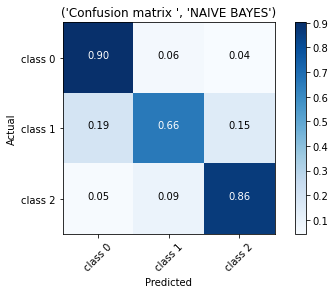

CLASSIFICATION REPORT:  NAIVE BAYES
              precision    recall  f1-score   support

          -1       0.89      0.90      0.89       509
           0       0.58      0.66      0.62       170
           1       0.91      0.86      0.89       553

    accuracy                           0.85      1232
   macro avg       0.79      0.81      0.80      1232
weighted avg       0.86      0.85      0.85      1232

=========================MODEL NAME:  KNN =========================


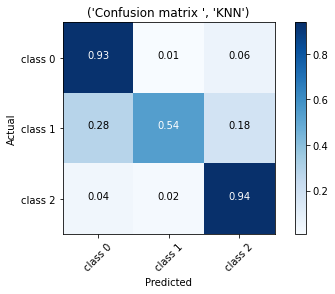

CLASSIFICATION REPORT:  KNN
              precision    recall  f1-score   support

          -1       0.87      0.93      0.90       509
           0       0.85      0.54      0.66       170
           1       0.89      0.94      0.92       553

    accuracy                           0.88      1232
   macro avg       0.87      0.80      0.82      1232
weighted avg       0.88      0.88      0.87      1232

=========================MODEL NAME:  Support Vector Machine Model =========================
[LibSVM]

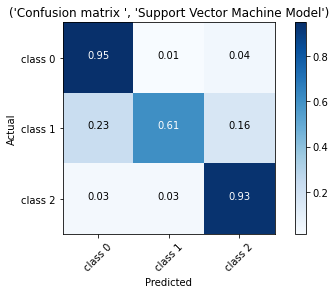

CLASSIFICATION REPORT:  Support Vector Machine Model
              precision    recall  f1-score   support

          -1       0.89      0.95      0.92       509
           0       0.80      0.61      0.69       170
           1       0.91      0.93      0.92       553

    accuracy                           0.89      1232
   macro avg       0.87      0.83      0.84      1232
weighted avg       0.89      0.89      0.89      1232

=========================MODEL NAME:  Decision Tree Classification Model =========================


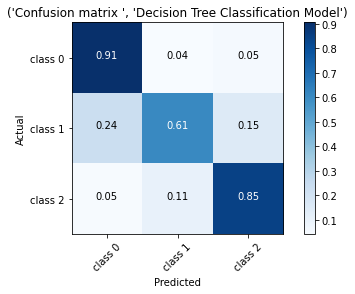

CLASSIFICATION REPORT:  Decision Tree Classification Model
              precision    recall  f1-score   support

          -1       0.88      0.91      0.89       509
           0       0.56      0.61      0.59       170
           1       0.90      0.85      0.87       553

    accuracy                           0.84      1232
   macro avg       0.78      0.79      0.78      1232
weighted avg       0.84      0.84      0.84      1232

=========================MODEL NAME:  Random Forest Classifier =========================


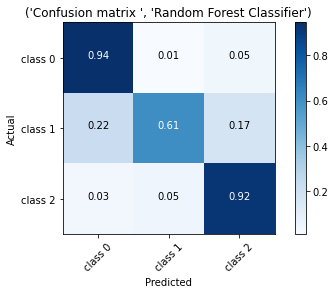

CLASSIFICATION REPORT:  Random Forest Classifier
              precision    recall  f1-score   support

          -1       0.90      0.94      0.92       509
           0       0.77      0.61      0.68       170
           1       0.91      0.92      0.91       553

    accuracy                           0.89      1232
   macro avg       0.86      0.82      0.84      1232
weighted avg       0.88      0.89      0.88      1232

=========================MODEL NAME:  Gradient Boosted Tree Classifier =========================


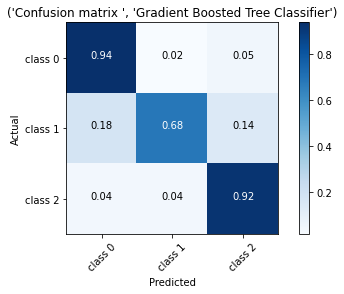

CLASSIFICATION REPORT:  Gradient Boosted Tree Classifier
              precision    recall  f1-score   support

          -1       0.90      0.94      0.92       509
           0       0.80      0.68      0.74       170
           1       0.91      0.92      0.92       553

    accuracy                           0.90      1232
   macro avg       0.87      0.85      0.86      1232
weighted avg       0.89      0.90      0.89      1232



In [35]:
optgrid ={}
df_acc_sg = pd.DataFrame()

df_acc_sg, m_idf_naive = naivebayes(xtrain,ytrain,xtest,ytest,class_names, n_class,df_acc_sg)

#The best hyperparameter: 0.892770105605199 {'n_neighbors': 3}
optgrid={'n_neighbors': 3}
df_acc_sg, m_sg_knn = knn(xtrain,ytrain,xtest,ytest,class_names, n_class,df_acc_sg,optgrid)

#The best hyperparameter: 0.9147034930950447 {'kernel': 'rbf', 'gamma': 0.01, 'C': 1000}
optgrid={'kernel': 'rbf', 'gamma': 0.01, 'C': 1000}
df_acc_sg, m_sg_svm = SVM(xtrain,ytrain,xtest,ytest,class_names, n_class,df_acc_sg,optgrid)

#The best hyperparameter: 0.8683996750609261 {'random_state': 523, 'min_samples_leaf': 8, 'max_depth': 50}
optgrid={'random_state': 523, 'min_samples_leaf': 8, 'max_depth': 50}
df_acc_sg, m_sg_dct = decision_tree_clf(xtrain,ytrain,xtest,ytest,class_names,n_class,df_acc_sg,optgrid)


#The best hyperparameter: 0.9073923639317628 {'random_state': 523, 'n_estimators': 150, 'max_features': 8, 'max_depth': 50}
optgrid={'random_state': 523, 'n_estimators': 150, 'max_features': 8, 'max_depth': 50}
df_acc_sg, m_sg_rft = random_forest_clf(xtrain,ytrain,xtest,ytest,class_names,n_class,df_acc_sg,optgrid)


#The best hyperparameter: 0.909017059301381 {'random_state': 523, 'n_estimators': 1000, 'max_features': 7, 'learning_rate': 0.1}
optgrid= {'random_state': 523, 'n_estimators': 1000, 'max_features': 7, 'learning_rate': 0.1}
df_acc_sg, m_sg_gdb = GradientBoostedclf(xtrain,ytrain,xtest,ytest,class_names,n_class,df_acc_sg,optgrid)

df_acc_sg['Feature Engineering'] = 'Skip_Gram'

In [36]:
df_acc_sg.sort_values(by=['Fscore','Accuracy', 'Rsquare Train','R-square Test'], inplace=True, ascending=False)
df_acc_sg

,Model,Rsquare Train,R-square Test,MAE Train,MAE Test,Accuracy,Fscore,Precision,Recall,Support,Test Duration,Confusion Martrix Duration,Classification Report Duration,Training_duration,Feature Engineering
5,Gradient Boosted Tree Classifier,0.999304,0.895292,1.9,397.7,0.895292,0.857892,0.871893,0.847242,None,0.309173,0.255288,0.350063,20.004974,Skip_Gram
2,Support Vector Machine Model,0.913679,0.893669,311.9,384.1,0.893669,0.844238,0.869197,0.828643,None,1.494003,0.369038,1.455109,2.533225,Skip_Gram
4,Random Forest Classifier,0.999304,0.887175,1.9,409.1,0.887175,0.837050,0.857227,0.823769,None,0.186500,0.268286,0.180514,7.828330,Skip_Gram
1,KNN,0.914027,0.879870,308.0,456.8,0.879870,0.824223,0.871693,0.801683,None,0.517612,0.407938,0.480685,0.004961,Skip_Gram
0,NAIVE BAYES,0.841281,0.850649,541.9,522.7,0.850649,0.800046,0.794398,0.807720,None,0.054855,0.304188,0.066820,0.026928,Skip_Gram
3,Decision Tree Classification Model,0.928646,0.838474,244.6,570.5,0.838474,0.782748,0.778954,0.787918,None,0.022942,0.500659,0.039892,2.174206,Skip_Gram


In [37]:
## SKIP-GRAM
modelfinename = "GenSim_sg_GradientBoostedClfModel.pickle"
save_models(m_sg_gdb, modelfinename)

modelfinename = "GenSim_sg_SVMClfModel.pickle"
save_models(m_sg_svm, modelfinename)

modelfinename = "GenSim_sg_RFTClfModel.pickle"
save_models(m_sg_rft, modelfinename)

# <font color='BLUE'> RESULTS </font>

In [38]:
df_acc = df_acc_bow.copy()
df_acc=df_acc.append(df_acc_tf)
df_acc=df_acc.append(df_acc_sg)
df_acc.sort_values(by=['Fscore','Accuracy', 'Rsquare Train','R-square Test'], inplace=True, ascending=False)
df_acc.to_csv(buffer_folder + 'Evaluate_Result.csv', index = False)
df_acc[['Model','Feature Engineering','Rsquare Train','R-square Test','MAE Train', 'MAE Test', 'Accuracy', 'Fscore','Training_duration']]

,Model,Feature Engineering,Rsquare Train,R-square Test,MAE Train,MAE Test,Accuracy,Fscore,Training_duration
2,Support Vector Machine Model,BoW,0.988862,0.938312,36.1,238.6,0.938312,0.924648,52.573105
5,Gradient Boosted Tree Classifier,BoW,0.994779,0.931006,16.6,243.2,0.931006,0.908380,8.153292
2,Support Vector Machine Model,TF-IDF,0.994779,0.926948,18.5,265.9,0.926948,0.899414,127.451061
5,Gradient Boosted Tree Classifier,TF-IDF,0.997912,0.908279,5.8,352.3,0.908279,0.884303,8.035508
5,Gradient Boosted Tree Classifier,Skip_Gram,0.999304,0.895292,1.9,397.7,0.895292,0.857892,20.004974
2,Support Vector Machine Model,Skip_Gram,0.913679,0.893669,311.9,384.1,0.893669,0.844238,2.533225
4,Random Forest Classifier,Skip_Gram,0.999304,0.887175,1.9,409.1,0.887175,0.837050,7.828330
3,Decision Tree Classification Model,TF-IDF,0.895231,0.841721,462.0,727.3,0.841721,0.834632,4.105088
3,Decision Tree Classification Model,BoW,0.922381,0.840909,336.2,706.8,0.840909,0.829151,2.109359
1,KNN,Skip_Gram,0.914027,0.879870,308.0,456.8,0.879870,0.824223,0.004961


# <font color='RED'> Predict using saved models </font>

In [39]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# https://towardsdatascience.com/nlp-for-beginners-cleaning-preprocessing-text-data-ae8e306bef0f
# Cleaning & Preprocessing Text Data
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from contractions import CONTRACTION_MAP
from nltk.corpus import wordnet

start_time = time.time()
tokenizer = RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def text_nomalization(df,colname):
    # remove empty rows
    df=df.dropna()
    # remove number in the review sentences
    df.loc[:,(colname)] = df[colname].str.replace('\d+', '')
    # remove_punctuation
    df.loc[:,(colname)] = df[colname].str.replace('[^\w\s]', '') 
    df.loc[:,(colname)] = df[colname].str.replace(r'[^\x00-\x7F]+', '')
    df.loc[:,(colname)] = df[colname].str.lower()
    # remove duplicated comments/reviews
    df.drop_duplicates(subset=colname, keep = "first", inplace = True)
    return df

def remove_html(text):
    soup= BeautifulSoup(text,'lxml')
    html_free = soup.get_text()
    return html_free

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def remove_stopwords(text):
    words = [word for word in nltk.word_tokenize(text) if word not in stopwords.words('english')]    
    return words

def word_lemmatizer(text):
    lem_text = ([lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in text])
#     clean_text = ' '.join(word for word in lem_text)
    return lem_text

def word_stemmer(text):
    stem_text = ([stemmer.stem(word) for word in text])
    #clean_text = ' '.join(word for word in stem_text)
    return stem_text

def join(token_text):
    sent = ' '.join(word for word in token_text)
    return sent

def text_processing(df,colname, do_stemmer=1):
    start_process = time.time()
    df = text_nomalization(df,colname)    
    print("+++++ text_nomalization duration--- %s seconds ---" % (time.time() - start_process))
    
    start_process = time.time()    
    df.loc[:,(colname)] = df[colname].apply(lambda x: remove_html(x))
    print("+++++ remove_html duration--- %s seconds ---" % (time.time() - start_process))
    
    start_process = time.time()    
    df.loc[:,(colname)] = df[colname].apply(lambda x: expand_contractions(x))
    print("+++++ expand_contractions duration--- %s seconds ---" % (time.time() - start_process))
    
#     start_process = time.time()    
#     df[colname] = df[colname].apply(lambda x: tokenizer.tokenize(x.lower()))
#     print("+++++ tokenizer duration--- %s seconds ---" % (time.time() - start_process))
    
    start_process = time.time()    
    df.loc[:,(colname)] = df[colname].apply(lambda x: remove_stopwords(x))
    print("+++++ remove_stopwords duration--- %s seconds ---" % (time.time() - start_process))
  
    start_process = time.time()    
    df.loc[:,(colname)] = df[colname].apply(lambda x: word_lemmatizer(x))
    print("+++++ word_lemmatizer duration--- %s seconds ---" % (time.time() - start_process))

    if (do_stemmer==1):
        start_process = time.time()    
        df.loc[:,(colname)] = df[colname].apply(lambda x: word_stemmer(x))
        print("+++++ word_stemmer duration--- %s seconds ---" % (time.time() - start_process))
    
    start_process = time.time()    
    df.loc[:,(colname)] = df[colname].apply(lambda x: join(x))
    print("+++++ join duration--- %s seconds ---" % (time.time() - start_process))
    
    return df

In [40]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

def fit_bow(X):
    cv = CountVectorizer() #max_features= 10000
    cv.fit_transform(X)
    return cv

def fit_tf_idf(X):
    tfv = TfidfVectorizer(analyzer='word',ngram_range=(1,3), token_pattern=r'\w{1,}',max_features=10000,stop_words=stopwords.words('english'))   # max_features=10000
    tfv.fit_transform(X)
    return tfv


def do_prediction(df_review,colname, features, features_filename, clf_model_filename, embedding_model_file=''):
    # 1.Text Processing
    df_review = text_processing(df_review,colname)    
    lst_review=df_review[colname].values.astype(str).tolist()
    
    # 2.Vectorization using trained features
    if (features=='idf'):
        with open(features_filename) as file:
            data = file.read()    
        data=[data]
        tfv = fit_tf_idf(data)
        X_test_vect = tfv.transform(lst_review).toarray()
    elif (features=='bow'):
        with open(features_filename) as file:
            data = file.read()    
        data=[data]
        cv = fit_bow(data)
        X_test_vect = cv.transform(lst_review).toarray()
    elif (features=='w2v_sg'):  
        X_test_vect=[]
        tokenize_colname = 'tokenized_comments'   
        df_review[tokenize_colname] = df_review[colname].apply(lambda x: tokenizer.tokenize(str(x)))
        emb_model = Word2Vec.load(embedding_model_file)
        for index, row in df_review.iterrows():
            model_vector = np.mean([emb_model[token] for token in row[tokenize_colname]], axis=0).tolist()         
            if type(model_vector) is list:  
                X_test_vect.append(model_vector)
    
    # 3.Load saved model
    loaded_model = pickle.load(open(clf_model_filename, 'rb'))
    
    # 4.Do prediction
    Y_test = loaded_model.predict(X_test_vect)
    
    return Y_test

In [41]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import nltk
import string
from nltk.tokenize import RegexpTokenizer
from gensim.models import Word2Vec

tokenizer = RegexpTokenizer(r'\w+')
test_folder = './data/test/'
test_file = test_folder + 'reviews_NewBrunswick_20210130.csv'

    
tfidf_features_filename = saved_embedding + 'bow_features.txt'
bow_features_filename = saved_embedding + 'bow_features.txt'

df_test = pd.read_csv(test_file)
colname = 'comments'



# PREDICT USING GRADIENT BOOSTED CLASSIFIER
features = "idf"
clf_model_filename = saved_models + 'idfGradientBoostedClfModel.pickle'
y_pred_idf = do_prediction(df_test,colname,features,tfidf_features_filename, clf_model_filename)
 
features = "bow"
clf_model_filename = saved_models + 'bowGradientBoostedClfModel.pickle'
y_pred_bow = do_prediction(df_test,colname,features,bow_features_filename, clf_model_filename)


features = "w2v_sg"
clf_model_filename = saved_models + 'GenSim_sg_GradientBoostedClfModel.pickle'
embedding_model_file= saved_models + 'w2vect_gensim_sg_256.model'
y_pred_sg = do_prediction(df_test,colname,features, '', clf_model_filename, embedding_model_file)

print('GRADIENT BOOSTED CLASSIFICATION')
df_result=df_test.copy()
df_result['IDF'] = y_pred_idf
df_result['BOW'] = y_pred_bow
df_result['Skip-Gram'] = y_pred_sg
df_result

+++++ text_nomalization duration--- 0.010970830917358398 seconds ---
+++++ remove_html duration--- 0.007978677749633789 seconds ---
+++++ expand_contractions duration--- 0.014960050582885742 seconds ---
+++++ remove_stopwords duration--- 0.34407973289489746 seconds ---
+++++ word_lemmatizer duration--- 2.4115495681762695 seconds ---
+++++ word_stemmer duration--- 0.010964632034301758 seconds ---
+++++ join duration--- 0.0009970664978027344 seconds ---
+++++ text_nomalization duration--- 0.007979154586791992 seconds ---
+++++ remove_html duration--- 0.007978439331054688 seconds ---
+++++ expand_contractions duration--- 0.011967658996582031 seconds ---
+++++ remove_stopwords duration--- 0.2753169536590576 seconds ---
+++++ word_lemmatizer duration--- 0.3210897445678711 seconds ---
+++++ word_stemmer duration--- 0.01096963882446289 seconds ---
+++++ join duration--- 0.000997781753540039 seconds ---
+++++ text_nomalization duration--- 0.006983041763305664 seconds ---
+++++ remove_html dura

,listing_id,id,date,reviewer_id,reviewer_name,comments,labelled_by_Human,IDF,BOW,Skip-Gram
0,75065,37146364,2015-07-05,30350931,Angie,We spent 4 nights at this beautiful cottage an...,1,0,1,1
1,75065,201946306,2017-10-09,133133,Shilei,We loved staying here! Having coffee and watch...,1,1,1,1
2,75065,279042769,2018-06-19,191448626,Sherri,Bob was an owner who was easily reachable if I...,1,0,1,1
3,75065,521126168,2019-08-31,122493946,Carrie,This location is amazing. It is close enough ...,1,0,1,1
4,261800,664324641,2020-09-14,11266797,Laurie,A very roomy and comfortable apartment - it co...,1,-1,1,1
5,950843,332982712,2018-10-06,213886811,Amanda,"Excellent service, lovely home with the extras...",1,0,1,1
6,950843,520524074,2019-08-30,287645565,Nadine,Gerry made our first Airbnb experience a fanta...,0,0,0,-1
7,950843,581337664,2019-12-24,167838293,Kelsey,Great spot,1,0,0,1
8,950843,613106634,2020-03-01,245658668,Isabelle,Host is great but the place was unfortunately ...,-1,0,1,1
9,986301,171895620,2017-07-19,31722140,David,Very spacious house with friendly owners. 3 se...,0,-1,1,1


In [42]:
# pip install wordcloud

In [43]:
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

In [44]:
# wrap the plotting in a function for easier access
def plot_wordcloud(df, language):
    wordcloud = WordCloud(max_font_size=None, max_words=200, background_color="lightgrey", 
                      width=3000, height=2000,
                      stopwords=stopwords.words('english')).generate(str(df.comments.values))
    
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title(language + ' Comments\n', fontsize=18, fontweight='bold')
    plt.show()

In [45]:
df_pos= df[(df['label'] == 1)]
df_neg= df[(df['label'] == -1)]

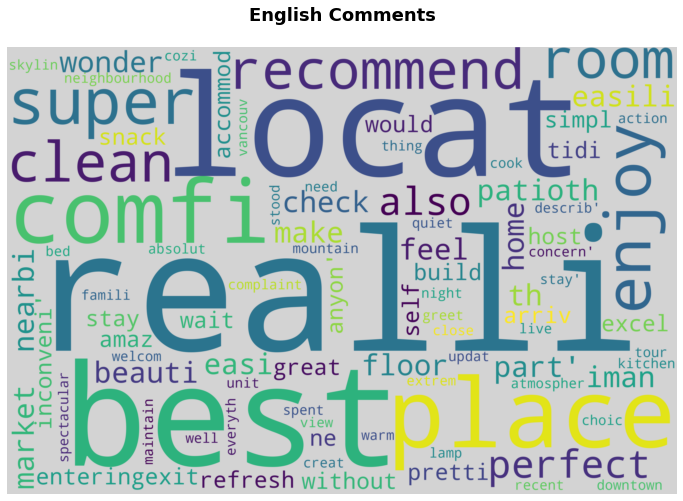

In [46]:
plot_wordcloud(df_pos, 'English')

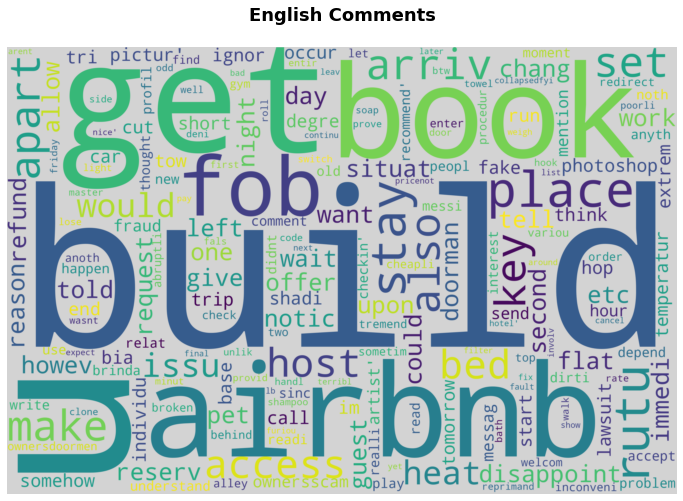

In [47]:
plot_wordcloud(df_neg, 'English')